# 專案介紹 - 透過銷售資料進行客戶分群


資料集：https://www.kaggle.com/c/instacart-market-basket-analysis/data

orders.csv: 所有顧客的訂單，分為之前的訂單（prior）、訓練集（train）和測試集（test）

products.csv: 銷售的產品清單

aisles.csv: 關於走道的資訊：

departments.csv: 關於產品種類的資訊：

order_products__train.csv 和 order_products__prior.csv: 提供每個訂單中的產品資訊

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
order_products_prior_df = pd.read_csv('./data/order_products__prior.csv')
order_products_train_df = pd.read_csv('./data/order_products__train.csv')
orders_df = pd.read_csv('data/orders.csv')
products_df = pd.read_csv('data/products.csv')
aisles_df = pd.read_csv('data/aisles.csv')
departments_df = pd.read_csv('data/departments.csv')

### 1. EDA (探索性資料分析)

所有顧客的訂單之前的訂單（prior）、訓練集（train）和測試集（test）分布狀況

<function matplotlib.pyplot.show(close=None, block=None)>

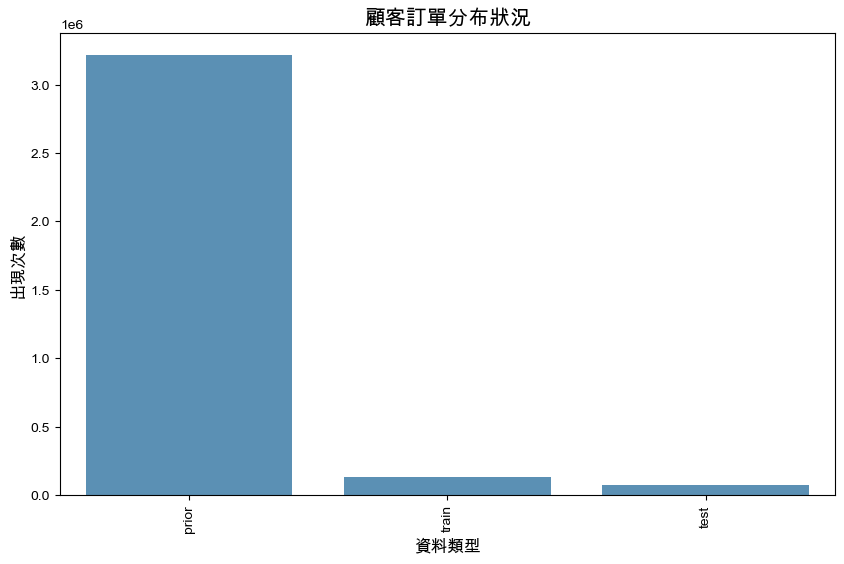

In [13]:
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False
cnt_sts = orders_df.eval_set.value_counts()
color = sns.color_palette()
plt.figure(figsize = (10,6))
sns.barplot(x=cnt_sts.index, y=cnt_sts.values, alpha=0.8, color=color[0])
plt.ylabel('出現次數' , fontsize = 12 )
plt.xlabel('資料類型' , fontsize = 12)
plt.title('顧客訂單分布狀況' , fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show

顧客總數

In [14]:
def get_unique_count(x):
    return len(np.unique(x))
cnt_srs = orders_df.groupby('eval_set')['user_id'].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

總共有 206209 的顧客
- - -

顧客訂單數分佈狀況

/var/folders/y3/s_9_ty0j55q1dj85jtbwv3vc0000gn/T/ipykernel_51919/1484075609.py:1: FutureWarning: The provided callable <function amax at 0x106b08b80> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()


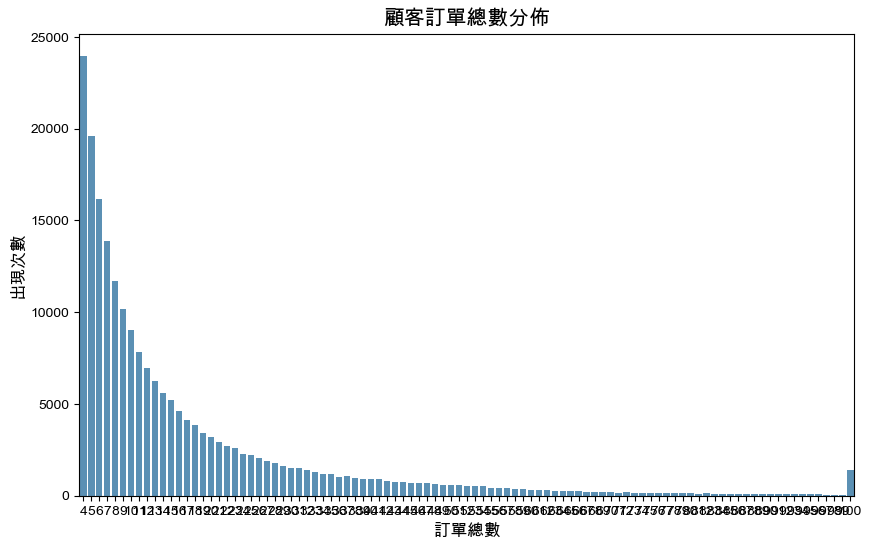

In [15]:
cnt_srs = orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('出現次數', fontsize=12)
plt.xlabel('訂單總數', fontsize=12)
plt.title('顧客訂單總數分佈' , fontsize = 15)
plt.show()

訂單總數最低為4筆，最高則是100筆
***

最多顧客消費的星期

官方數據的說明中，未提供 order_row 欄位中 0-6 所代表的實際星期，因此推測，大多數顧客的消費行為多集中在週末，因此將 0 視為星期六，1 視為星期日，以此類推。

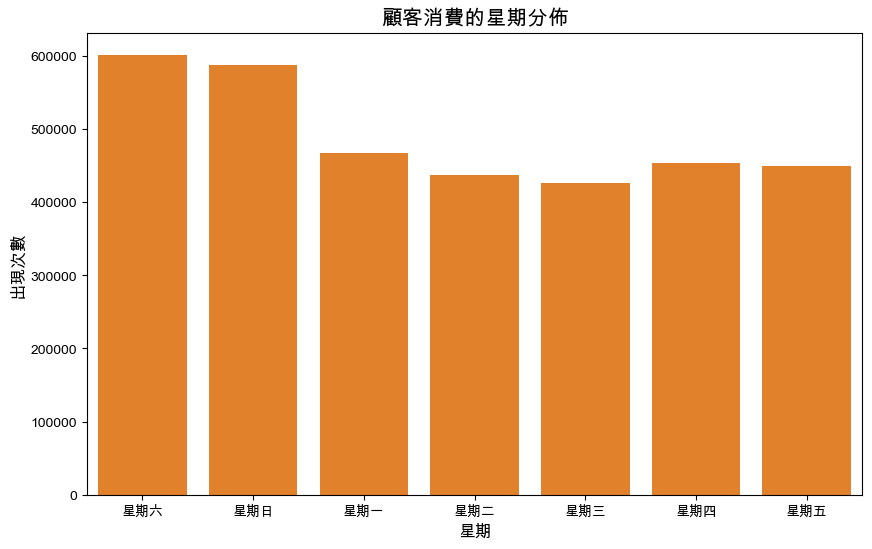

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_dow', data=orders_df, color=color[1])
plt.xticks(range(7), ['星期六', '星期日', '星期一', '星期二', '星期三', '星期四', '星期五'])
plt.ylabel('出現次數', fontsize=12)
plt.xlabel('星期', fontsize=12)
plt.title('顧客消費的星期分佈', fontsize=15)
plt.show()

結果顯示星期六和星期日為最多人消費的日子，而禮拜三的人最少
***

最多人消費的時段

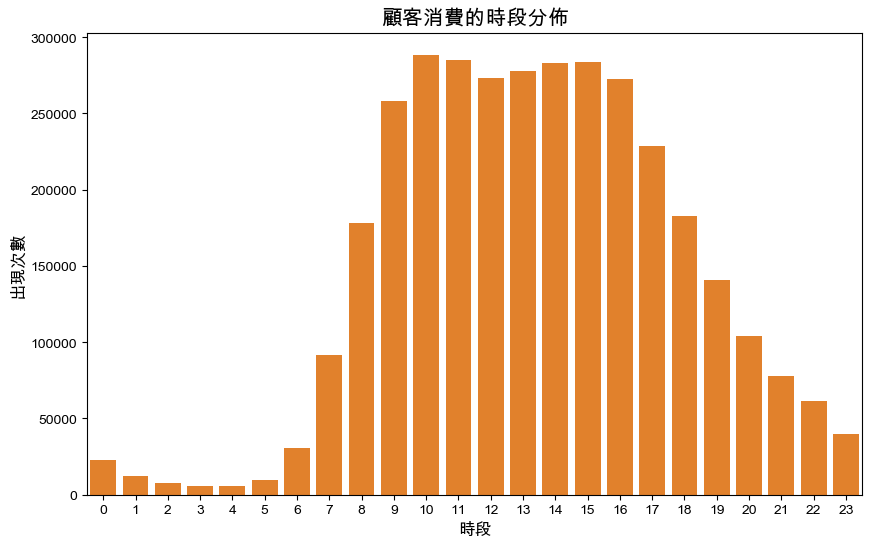

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_hour_of_day', data=orders_df, color=color[1])
plt.ylabel('出現次數', fontsize=12)
plt.xlabel('時段', fontsize=12)
plt.title('顧客消費的時段分佈', fontsize=15)
plt.show()

結果顯示上午十點至下午五點為最多顧客消費的時段，而凌晨一點至凌晨五點最少
***

使用熱點圖查看日期與時段的關係

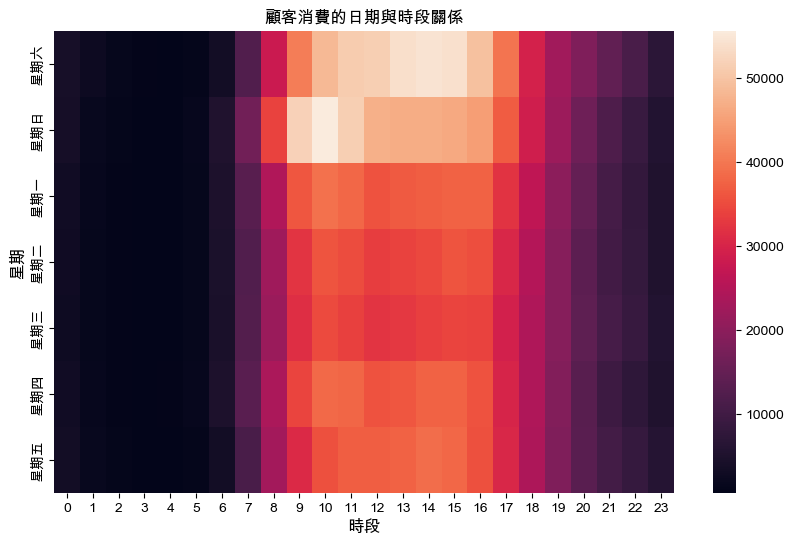

In [18]:
grouped_df = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')
dow_labels = ['星期六', '星期日', '星期一', '星期二', '星期三', '星期四', '星期五']

plt.figure(figsize=(10, 6))
sns.heatmap(grouped_df, yticklabels=dow_labels)
plt.ylabel('星期', fontsize=12)
plt.xlabel('時段', fontsize=12)
plt.title('顧客消費的日期與時段關係')
plt.show()

結果顯示，星期六下午一點至三點、星期日早上九點至十點為最熱門的時段，得知以上資訊，商家可以：

1. 增加熱門時段的人手：在客流高峰時段，增派工作人員以改善顧客服務，縮短結帳時間，並確保貨架上商品充足。

2. 提前進行庫存管理：預測這些高峰時段可能會增加的商品需求，提前進行補貨，確保熱銷商品的供應不會中斷。

3. 推出時間限定促銷：利用這些高峰時段推出特價商品或促銷活動，吸引更多顧客前來購物，增加銷售額。
***

顧客消費頻率

days_since_prior_order 欄位為同一顧客自從上次消費所計算的天數，因此透過次欄位來計算顧客消費頻率

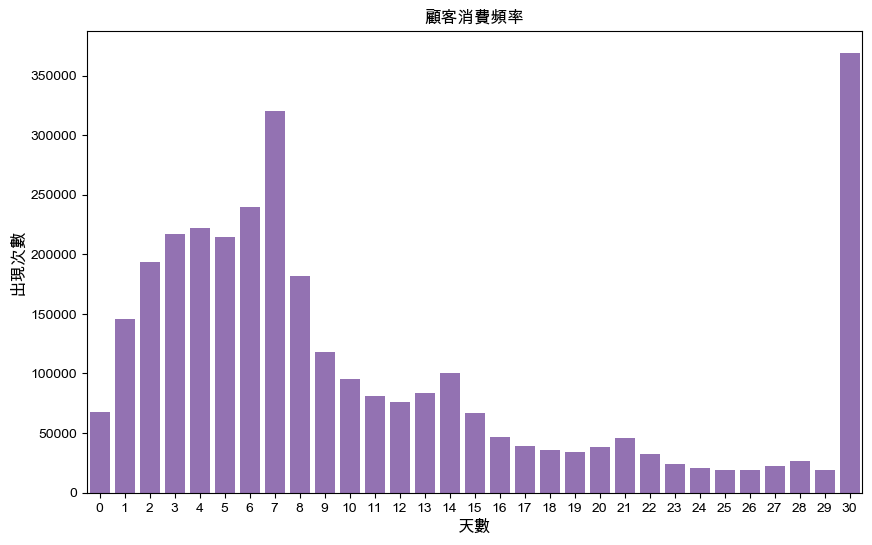

In [19]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(10, 6))
sns.countplot(x='days_since_prior_order', data=orders_df, color=color[4])
plt.xlabel('天數', fontsize=12)
plt.ylabel('出現次數', fontsize=12)
def format_func(value, tick_number):
    return f'{int(value)}'
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.title('顧客消費頻率')
plt.show()

結果顯示，30天消費一次的頻率異常的高，而次高的天數為7天消費一次，反應了顧客或許固定每週都至超市購買商品

In [20]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
basic_stats = orders_df['days_since_prior_order'].describe()
basic_stats

count   3214874.00
mean         11.11
std           9.21
min           0.00
25%           4.00
50%           7.00
75%          15.00
max          30.00
Name: days_since_prior_order, dtype: float64

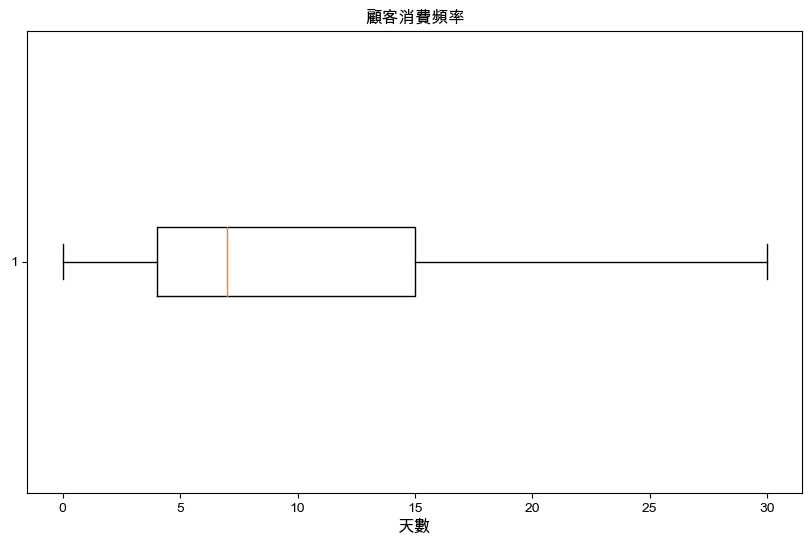

In [21]:
plt.figure(figsize=(10, 6))
plt.boxplot(orders_df['days_since_prior_order'].dropna(), vert=False)
plt.title('顧客消費頻率')
plt.xlabel('天數', fontsize=12)
plt.show()

進一步進行分析，發現顧客消費頻率平均天數約為11.11天，標準差為9.21天，顯示訂單間隔天數具有相當的變異，中位數為7天，意味著一半的訂單間隔在7天內，最大值是30天，這可能是系統設定的最大間隔值，推測超過30天的天數都會記錄在30天。
***

查看商品被重複購買的比例

In [22]:
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

結果顯示商品被重複購買的比例約為0.6，可以用來分析客戶行為，幫助商家了解哪些商品具有較高的客戶忠誠度
***

查看顧客購買的商品數量分佈


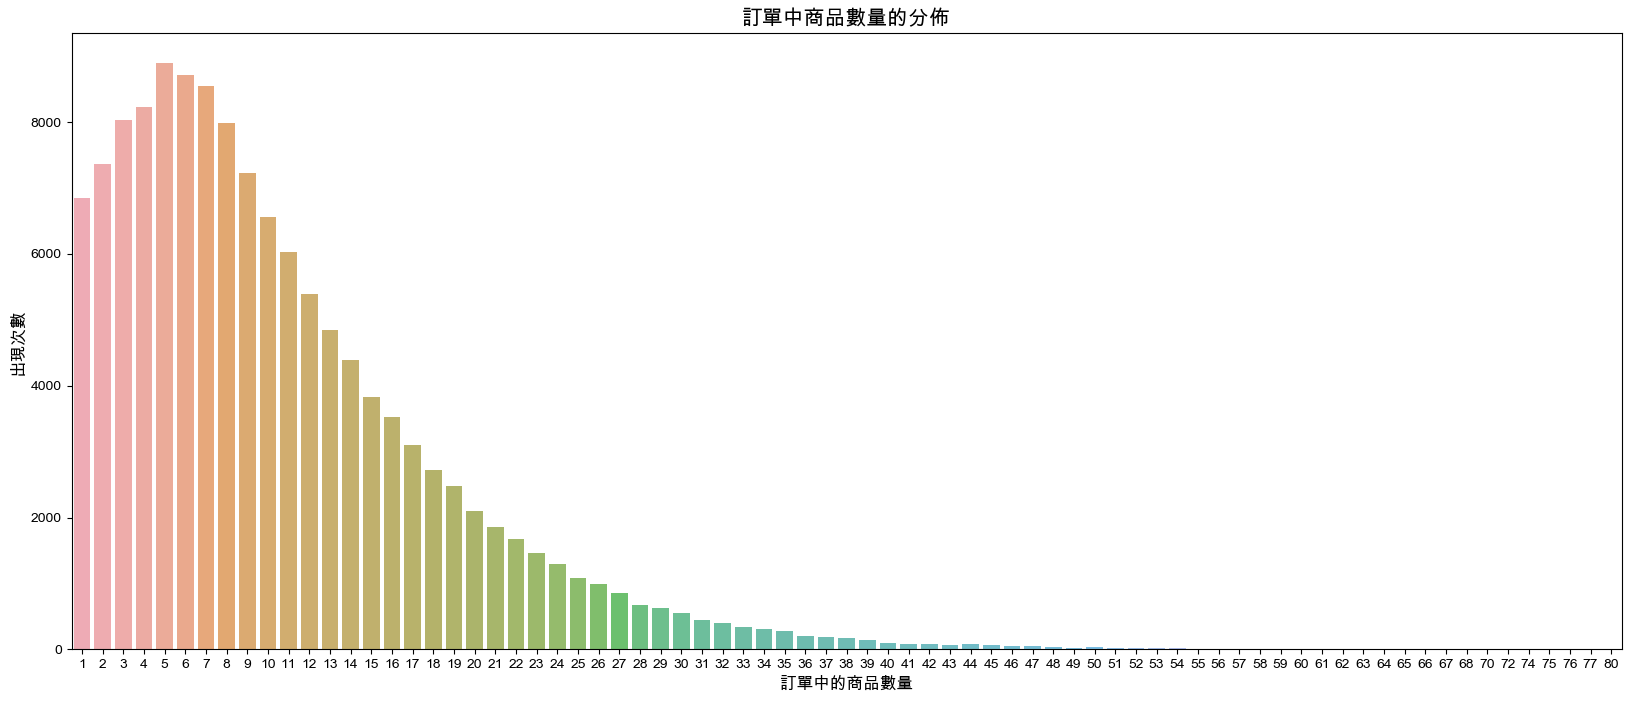

In [23]:
grouped_df = order_products_train_df.groupby('order_id')['add_to_cart_order'].aggregate('max').reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('出現次數', fontsize=12)
plt.xlabel('訂單中的商品數量', fontsize=12)
plt.title('訂單中商品數量的分佈', fontsize=15)
plt.xticks(rotation=0)
plt.show()

結果顯示，多數人購買約五至七樣商品
***

最常被購買的商品

In [24]:
order_products_prior_df = pd.merge(order_products_prior_df , products_df , on  = 'product_id' ,  how= 'left')
order_products_prior_df = pd.merge(order_products_prior_df , aisles_df , on = 'aisle_id' , how = 'left')
order_products_prior_df = pd.merge(order_products_prior_df , departments_df ,on = 'department_id' , how = 'left')
order_products_prior_df.head()
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['商品名稱' , '出現次數']
cnt_srs

,商品名稱,出現次數
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


結果顯示：
1. 偏好有機產品：有機產品的出現頻率非常高，如「Bag of Organic Bananas」、「Organic Strawberries」和「Organic Baby Spinach」等，顯示出消費者對有機產品有很高的偏好。

2. 水果類商品熱門：水果類產品尤其受到歡迎，例如「Banana」、「Organic Strawberries」和「Large Lemon」等，顯示水果為日常購物清單中的常見選擇。

3. 頻繁購買的基本食材：除了水果外，其他像是「Organic Baby Spinach」、「Organic Avocado」和「Organic Whole Milk」這類日常飲食基本食材也在購買次數上排名靠前，這可能與健康飲食趨勢相關。
***

加入購物車的順序與重購比率的關聯

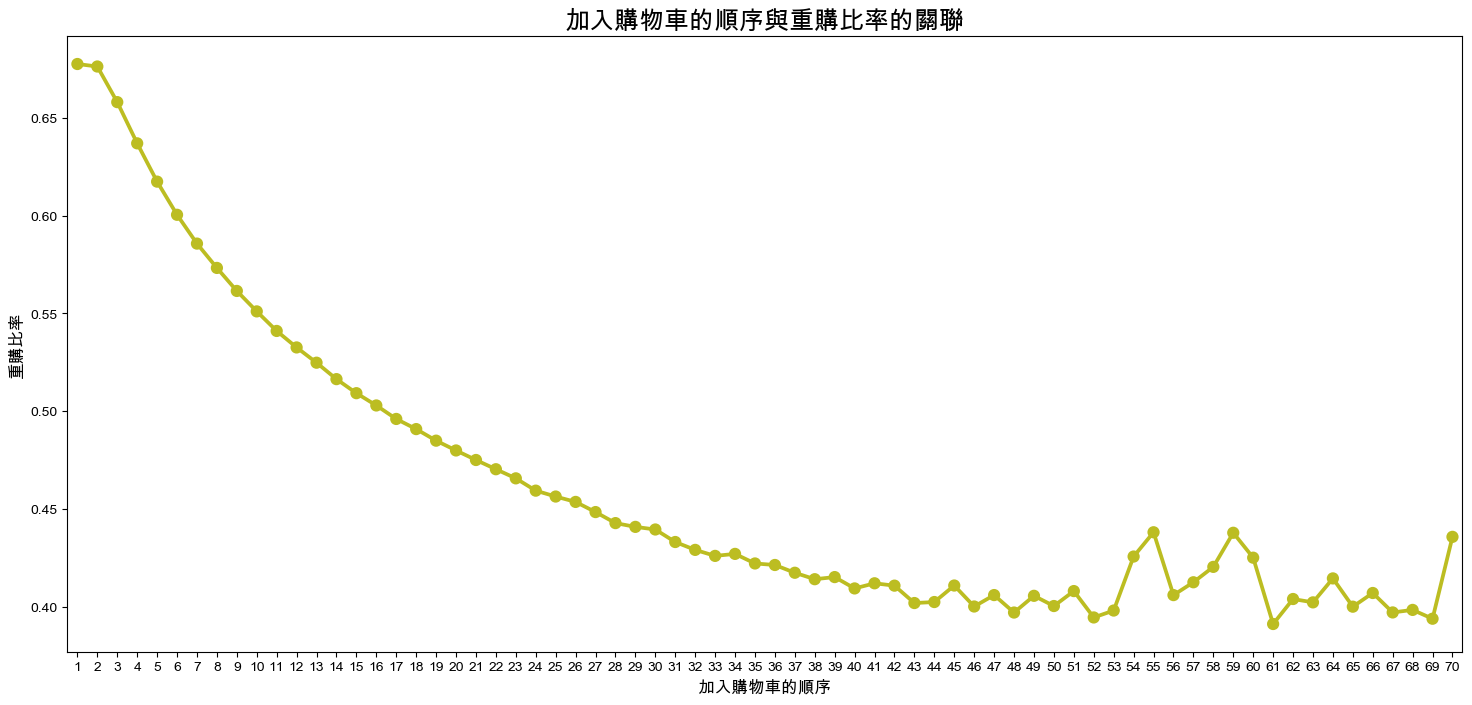

In [25]:
order_products_prior_df['add_to_cart_mod'] = order_products_prior_df['add_to_cart_order'].copy()
order_products_prior_df.loc[order_products_prior_df['add_to_cart_mod'] > 70, 'add_to_cart_mod'] = 70
grouped_df = order_products_prior_df.groupby('add_to_cart_mod')['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(18, 8))
sns.pointplot(x='add_to_cart_mod', y='reordered', data=grouped_df, color=color[8])
plt.ylabel('重購比率', fontsize=12)  
plt.xlabel('加入購物車的順序', fontsize=12)  
plt.title('加入購物車的順序與重購比率的關聯', fontsize=18)  
plt.show()

結果顯示，如果某個商品較早被添加到購物車中，它的重購率可能會較高
***

### 2. 使用 Kmeans 將客戶分群

計算每個用戶在不同走道的購買次數

In [26]:
mt = pd.merge(order_products_prior_df, orders_df, on = 'order_id')
orders_df.head()
cust_prod = pd.crosstab(mt['user_id'] , mt['aisle'])
cust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


資料降維

In [27]:
from sklearn. decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
cust_prod = pca.transform(cust_prod)
tocluster = pd.DataFrame(cust_prod) [[1,4]]

使用 Elbow function 尋找最佳的聚類數目（k值）

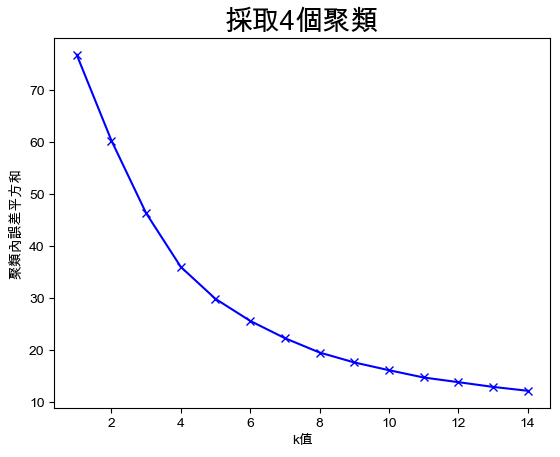

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
data_transformed = scaler.fit_transform(tocluster)

k_values = range(1, 15)
inertias = [KMeans(n_clusters=k).fit(data_transformed).inertia_ for k in k_values]

plt.plot(k_values, inertias, 'bx-')
plt.xlabel('k值')
plt.ylabel('聚類內誤差平方和')
plt.title('採取4個聚類', fontsize=20)
plt.show()

使用了 Silhouette 分析來評估 Kmeans 的效果

/Users/jimwu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


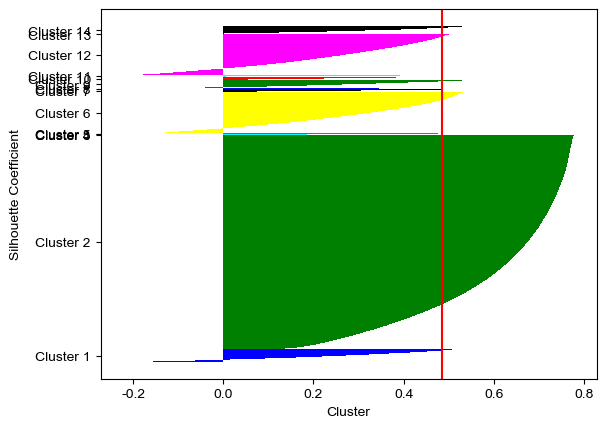

In [33]:
from sklearn.metrics import silhouette_samples
Y = model.fit_predict(data_transform)
cluster_labels = np.unique(Y)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(data_transform , Y , metric='euclidean')
y_ax_lower , y_ax_upper = 0 , 0
yticks = []

color = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'] * 3

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[Y == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    c_color = color[i]
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=c_color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='-')
plt.yticks(yticks, [f'Cluster {label+1}' for label in cluster_labels])
plt.xlabel('Cluster')
plt.ylabel('Silhouette Coefficient')
plt.show()

查看資料彼此間的情況

[[-40.617772    -4.71203144]
 [  0.09813797  -0.11856209]
 [ 65.26938505 -11.27562455]
 [ 26.26358548  76.82337865]]


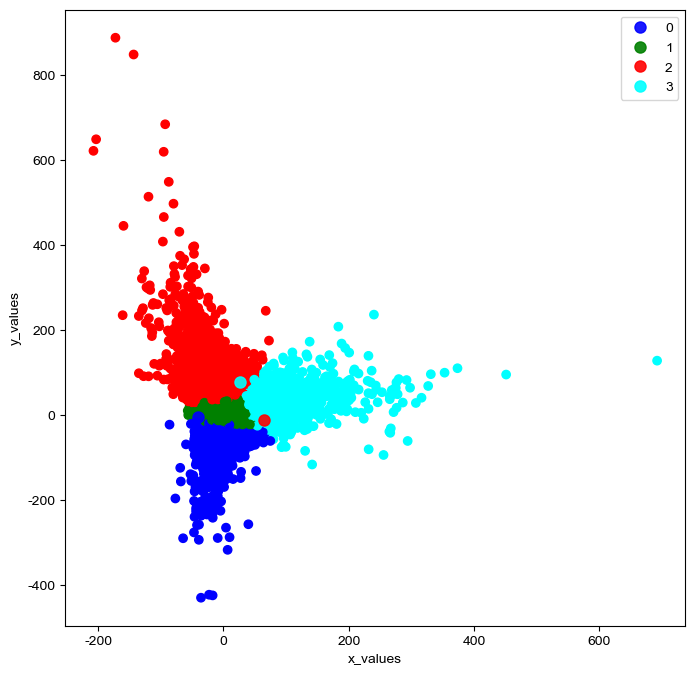

In [39]:
from sklearn.cluster import KMeans

n_clusters = 4
model = KMeans(n_clusters= n_clusters, random_state=42).fit(tocluster)
centers = model.cluster_centers_
c_preds = model.predict (tocluster)
print (centers)

plt.figure(figsize = (8,8))
colored = [color[k] for k in c_preds]
plt.scatter(tocluster[4], tocluster[1] , color = colored)
for ci, c in enumerate (centers) :
    plt.plot(c[0], c[1], 'o' , markersize = 8, color = color[ci], alpha = 0.9 , label = '' + str(ci))
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()

In [48]:
cust_prod = pd. crosstab(mt[ 'user_id'] , mt['aisle'])
cust_prod[ 'group'] = c_preds
cust_prod. head()
for group in range(n_clusters) :
    print( '組別' , str(group+1) , '的熱門商品' , '\n')
    print(cust_prod[cust_prod[ 'group'] == group].sum() .sort_values(ascending= False).head (5))
    print('=' * 20)
    print('\n')

組別 1 的熱門商品 

aisle
fresh vegetables              1080540
fresh fruits                   573204
packaged vegetables fruits     311258
fresh herbs                    126165
packaged cheese                118668
dtype: int64


組別 2 的熱門商品 

aisle
fresh fruits                  2433946
fresh vegetables              2109208
packaged vegetables fruits    1223242
yogurt                         906351
packaged cheese                703174
dtype: int64


組別 3 的熱門商品 

aisle
fresh fruits                     501654
yogurt                           374044
packaged vegetables fruits       167089
water seltzer sparkling water    153116
fresh vegetables                 135964
dtype: int64


組別 4 的熱門商品 

aisle
baby food formula             166018
fresh fruits                  133384
fresh vegetables               92309
packaged vegetables fruits     63724
yogurt                         61300
dtype: int64




將各個品項除上的商品類型來計算貢獻值

In [53]:
for group in range(n_clusters):
    print('組別', str(group+1), '的熱門商品', '\n')
    contributions = (cust_prod[cust_prod['group'] == group].sum() / cust_prod.sum()).drop('group').sort_values(ascending=False).head(10)
    display(contributions)
    print('=' * 20)
    print('\n')

組別 1 的熱門商品 



aisle
fresh herbs                    0.33
fresh vegetables               0.32
bulk grains rice dried goods   0.30
tofu meat alternatives         0.24
seafood counter                0.24
grains rice dried goods        0.23
canned jarred vegetables       0.23
meat counter                   0.23
spices seasonings              0.22
poultry counter                0.22
dtype: float64



組別 2 的熱門商品 



aisle
spirits                      0.91
white wines                  0.91
specialty wines champagnes   0.91
red wines                    0.91
eye ear care                 0.90
facial care                  0.89
beers coolers                0.87
shave needs                  0.87
air fresheners candles       0.86
body lotions soap            0.86
dtype: float64



組別 3 的熱門商品 



aisle
yogurt                         0.26
energy granola bars            0.25
granola                        0.23
tea                            0.22
mint gum                       0.21
trail mix snack mix            0.21
breakfast bars pastries        0.21
fruit vegetable snacks         0.19
candy chocolate                0.18
bulk dried fruits vegetables   0.18
dtype: float64



組別 4 的熱門商品 



aisle
baby food formula         0.43
baby accessories          0.14
diapers wipes             0.12
baby bath body care       0.10
canned fruit applesauce   0.07
frozen breakfast          0.06
fruit vegetable snacks    0.05
instant foods             0.05
milk                      0.05
fresh pasta               0.05
dtype: float64

結果顯示分群結果為：
1. 健康和天然食品

主要購買產品：草藥、蔬菜、穀物、豆類、乾貨、豆腐、肉類、海鮮等
特點：這一組顧客可能非常注重健康和自然飲食，偏好新鮮和有機產品。他們可能是素食者或者尋求高纖維、低脂肪的飲食方案，也可能熱衷於自己烹飪。

2. 酒類和個人護理產品

主要購買產品：葡萄酒、香檳、紅葡萄酒、啤酒、調酒器材、護理產品等
特點：這一組的顧客可能更偏向於享受生活，有較高的收入水平，喜歡聚會和社交活動。他們購買昂貴的酒類和高品質的個人護理產品，關注外表和個人形象。

3. 休閒食品和健康小食

主要購買產品：優格、燕麥棒、茶、口香糖、零食、糕點等
特點：這群顧客可能注重健康與便利，偏好快速且營養的食品選擇。可能是忙碌的專業人士或學生，尋找可以快速食用的健康零食。

4. 嬰幼兒護理和家庭產品

主要購買產品：嬰兒食品和配方奶、嬰兒用品、尿布、嬰兒洗護用品等
特點：這一組顧客主要可能是有小孩的家庭，特別是嬰幼兒，他們的購物清單集中在滿足嬰幼兒日常需要上。這些家庭可能在尋找方便和高品質的嬰兒用品，以確保孩子的健康和舒適。